# Comparing adaptive and constant step size SDE solvers for the SABR model

In [1]:
from helpers import SDE, simple_sde_order

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    AbstractBrownianPath,
    diffeqsolve,
    Euler,  # noqa: F401
    MultiTerm,
    ODETerm,
    PIDController,
    SABRController,
    SaveAt,
    SpaceTimeLevyArea,
    SPaRK,
    WeaklyDiagonalControlTerm,
)
from drawing_and_evaluating import (
    constant_step_strong_order,  # noqa: F401
    draw_order_multiple_dict,
    load_order_results,  # noqa: F401
    save_order_results,  # noqa: F401
)


jax.config.update("jax_enable_x64", True)


# Define the SABR model
def drift(t, y, args):
    return jnp.array([0.0, -0.5], dtype=y.dtype)


def diffusion(t, y, args):
    v = y[1]
    sigma = jnp.exp(v)
    return jnp.array([sigma, 1.0], dtype=y.dtype)


def get_terms(bm: AbstractBrownianPath):
    return MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, bm))


# Initial value is (0, 0)
y0 = jnp.array([0.0, 0.0], dtype=jnp.float64)

# Time will run from 0 to 10
t0, t1 = 0.0, 10.0

sabr_sde = SDE(get_terms, None, y0, t0, t1, (2,))

# We will use 50000 sample paths to estimate the order
num_samples = 50000
key = jr.key(6)
keys = jr.split(key, num_samples)

### Drawing of a single sample path

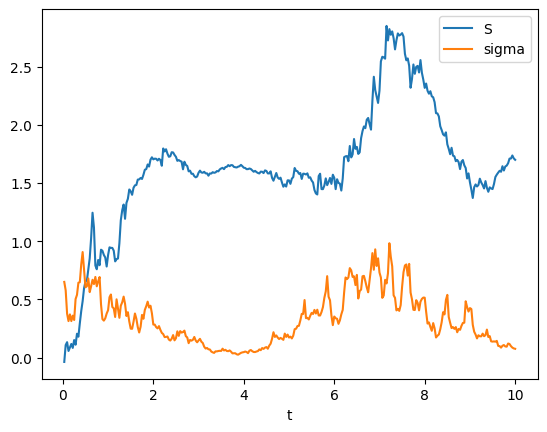

In [2]:
bm_key = jr.key(8)
terms_sabr = get_terms(sabr_sde.get_bm(bm_key, SpaceTimeLevyArea, 2**-6))
sol = diffeqsolve(terms_sabr, SPaRK(), t0, t1, 2**-5, y0, saveat=SaveAt(steps=True))
plt.plot(sol.ts, sol.ys[:, 0], label="S")
plt.plot(sol.ts, jnp.exp(sol.ys[:, 1]), label="sigma")
plt.xlabel("t")
plt.legend()
plt.show()

### Strong order using PID controller
The parameters $K_P = 0.1$ and $K_I = 0.3$ were chosen based on recommendations from the Diffrax documentation and from Ilie et al. (2015):

@article{ilie2015adaptive,
  author={Ilie, Silvana and Jackson, Kenneth R. and Enright, Wayne H.},
  title={{A}daptive {T}ime-{S}tepping for the {S}trong {N}umerical {S}olution
         of {S}tochastic {D}ifferential {E}quations},
  year={2015},
  publisher={Springer-Verlag},
  address={Berlin, Heidelberg},
  volume={68},
  number={4},
  doi={https://doi.org/10.1007/s11075-014-9872-6},
  journal={Numer. Algorithms},
  pages={791–-812},
}

In [3]:
def pid_strong_order(keys, sde, solver, levels, bm_tol=2**-13):
    save_ts_pid = jnp.linspace(sde.t0, sde.t1, 65, endpoint=True)

    def get_pid(level):
        return None, PIDController(
            pcoeff=0.1,
            icoeff=0.3,
            rtol=0,
            atol=2**-level,
            step_ts=save_ts_pid,
            dtmin=2**-10,
            force_dtmin=True,
        )

    saveat_pid = SaveAt(ts=save_ts_pid)
    return simple_sde_order(
        keys, sde, solver, solver, levels, get_pid, saveat_pid, bm_tol
    )


# spark_pid = pid_strong_order(keys, sabr_sde, SPaRK(), (0, 7))
# save_order_results(spark_pid, "spark_pid")
spark_pid = load_order_results("spark_pid")

# heun_pid = pid_strong_order(keys, sabr_sde, Heun(), (3, 9))
# save_order_results(heun_pid, "heun_pid")
heun_pid = load_order_results("heun_pid")

Loaded order_results/order_results_spark_pid.npy
Loaded order_results/order_results_heun_pid.npy


### Strong order using constant step size

In [4]:
# spark_const = constant_step_strong_order(keys, sabr_sde, SPaRK(), (4, 10))
# save_order_results(spark_const, "spark_const")
spark_const = load_order_results("spark_const")

# heun_const = constant_step_strong_order(keys, sabr_sde, Heun(), (6, 11))
# save_order_results(heun_const, "heun_const")
heun_const = load_order_results("heun_const")

# euler_const = constant_step_strong_order(keys, sabr_sde, Euler(), (6, 11))
# save_order_results(euler_const, "euler_const")
euler_const = load_order_results("euler_const")

Loaded order_results/order_results_spark_const.npy
Loaded order_results/order_results_heun_const.npy
Loaded order_results/order_results_euler_const.npy


### Strong order using the previsible step size optimized for the SABR model

In [5]:
def sabr_strong_order(keys, sde, solver, levels, previsible=False, euler=False):
    save_ts = jnp.linspace(sde.t0, sde.t1, 65, endpoint=True)
    _saveat = SaveAt(ts=save_ts)
    bm_tol = 2**-11

    def get_sabr_controller(level: int):
        return None, SABRController(
            ctol=2**-level,
            dtmin=2**-10,
            dtmax=1.0,
            step_ts=save_ts,
            previsible=previsible,
            euler=euler,
        )

    return simple_sde_order(
        keys, sde, solver, solver, levels, get_sabr_controller, _saveat, bm_tol
    )


# spark_sabr = sabr_strong_order(keys, sabr_sde, SPaRK(), (-4, 3))
# save_order_results(spark_sabr, "spark_sabr")
spark_sabr = load_order_results("spark_sabr")

# heun_sabr = sabr_strong_order(keys, sabr_sde, Heun(), (-4, 3))
# save_order_results(heun_sabr, "heun_sabr")
heun_sabr = load_order_results("heun_sabr")

# spark_previs = sabr_strong_order(keys, sabr_sde, SPaRK(), (-4, 4), previsible=True)
# save_order_results(spark_previs, "spark_previs")
spark_previs = load_order_results("spark_previs")

# heun_previs = sabr_strong_order(keys, sabr_sde, Heun(), (-3, 6), previsible=True)
# save_order_results(heun_previs, "heun_previs")
heun_previs = load_order_results("heun_previs")


# euler_previs = sabr_strong_order(keys, sabr_sde, Euler(), (-3, 6), previsible=True)
# save_order_results(euler_previs, "euler_previs")
euler_previs = load_order_results("euler_previs")

Loaded order_results/order_results_spark_sabr.npy
Loaded order_results/order_results_heun_sabr.npy
Loaded order_results/order_results_spark_previs.npy
Loaded order_results/order_results_heun_previs.npy
Loaded order_results/order_results_euler_previs.npy


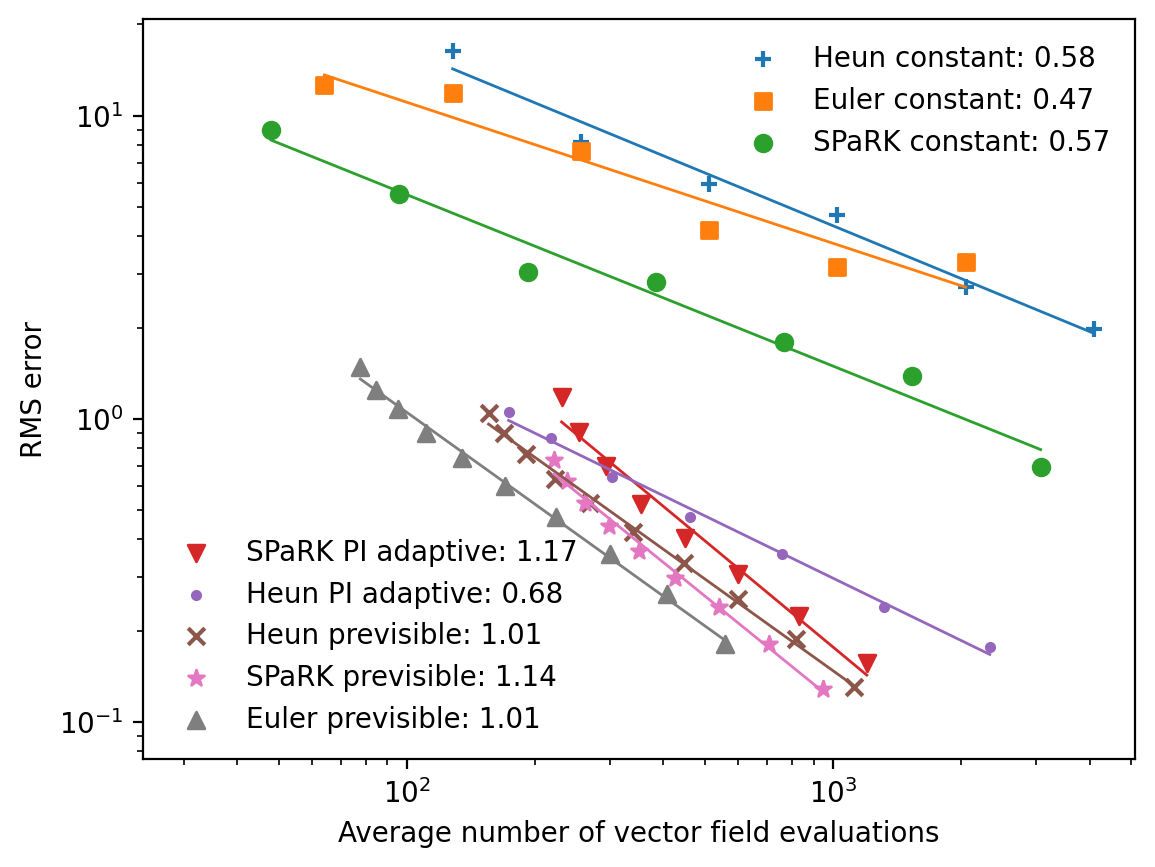

In [6]:
results2 = {
    "Heun constant": heun_const,
    "Euler constant": euler_const,
    "SPaRK constant": spark_const,
    "SPaRK PI adaptive": spark_pid,
    "Heun PI adaptive": heun_pid,
    "Heun previsible": heun_previs,
    "SPaRK previsible": spark_previs,
    "Euler previsible": euler_previs,
}

fig = draw_order_multiple_dict(results2)

In [9]:
name = "split_legend2"
fig.savefig(f"{name}.pdf")
fig.savefig(f"{name}.png")